In [1]:
from diffmain import *
from DataL import *
import glob
import sys
import os
import re
import torch    
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pdb

['apple', 'cat', 'rhinoceros', 'ant', 'tree', 'butterfly', 'sword', 'pear', 'strawberry', 'raccoon', 'bench', 'piano', 'crab', 'pig', 'blimp', 'hammer', 'hermit_crab', 'tank', 'snail', 'violin', 'ape', 'wading_bird', 'jack-o-lantern', 'cup', 'racket', 'turtle', 'hourglass', 'saw', 'mushroom', 'rifle', 'dog', 'alarm_clock', 'bee', 'couch', 'dolphin', 'scorpion', 'candle', 'giraffe', 'bear', 'flower', 'harp', 'penguin', 'pistol', 'zebra', 'sheep', 'lobster', 'duck', 'shoe', 'trumpet', 'church', 'camel', 'owl', 'tiger', 'motorcycle', 'guitar', 'chair', 'windmill', 'helicopter', 'starfish', 'sailboat', 'wheelchair', 'seal', 'jellyfish', 'cabin', 'mouse', 'saxophone', 'hotdog', 'lizard', 'beetle', 'table', 'skyscraper', 'parrot', 'armor', 'window', 'airplane', 'kangaroo', 'umbrella', 'spider', 'chicken', 'bell', 'eyeglasses', 'spoon', 'bread', 'hat', 'rabbit', 'scissors', 'bat', 'fan', 'sea_turtle', 'cannon', 'rocket', 'banana', 'swan', 'wine_bottle', 'axe', 'castle', 'hamburger', 'bicycle'

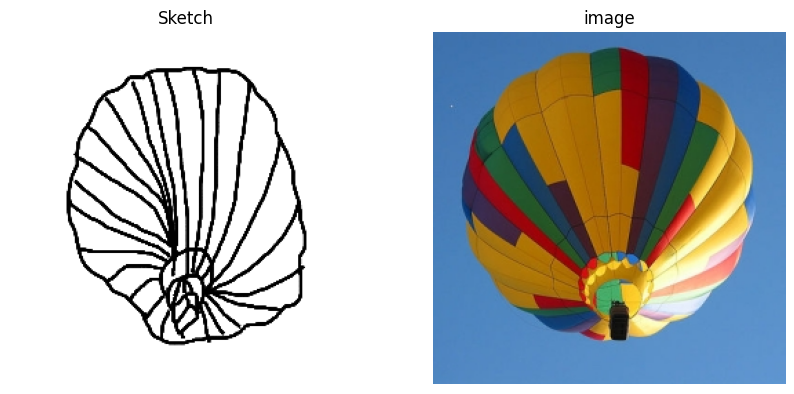

In [5]:

photos_dir = '/Users/deniskaanalpay/Desktop/CMU/Term_2/18786_Intro_to_DL/SketchtoImage/rendered_256x256/256x256/photo/tx_000100000000'
sketches_dir = '/Users/deniskaanalpay/Desktop/CMU/Term_2/18786_Intro_to_DL/SketchtoImage/rendered_256x256/256x256/sketch/tx_000100000000'
print(os.listdir(sketches_dir))
SketchySet = SketchyDataset(sketches_dir, photos_dir)

#SketchySet = get_dataset(photos_dir, sketches_dir)


train_loader = torch.utils.data.DataLoader(SketchySet, batch_size=256)


i=random.randint(0,len(SketchySet)-1)
sk,im = SketchySet[i]

# Convert the tensors back to numpy arrays
#sk = sk.numpy()
#im = im.numpy()

sk=np.array(sk)#.transpose((1,2,0))
im=np.array(im)#.transpose((1,2,0))
print(im)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(sk)
ax[0].set_title('Sketch')
ax[0].axis('off')

ax[1].imshow(im)
ax[1].set_title('image')
ax[1].axis('off')

plt.show()



In [12]:
diffusion_steps = 1000
architecture = "UNet"
sampling_steps = 250
DDIM = False
local_rank = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [13]:
model = unets.__dict__[architecture](
    image_size=128,
    in_channels=3,
    out_channels=3,
    num_classes=2)

diffusion = GuassianDiffusion(diffusion_steps, device = device)

lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr= 0.001)

In [15]:
epochs = 100

for epoch in range(epochs):
    for photo, sketch in train_loader:
        photo = photo.to("cpu")
        sketch = sketch.to("cpu")
        z = torch.randn(photo.shape[0], 3, 128, 128)
        z = z.to("cpu")
        for i in range(diffusion_steps):
            t = i / diffusion_steps
            z = diffusion.p_mean_variance(model, z, t, photo, 0.01, 1.0, noise = None)
        loss = F.mse_loss(z, sketch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss.item())
    print("Epoch: ", epoch)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89
Epoch:  90
Epoch:  9